In [1]:
!wget -q http://www.arts.chula.ac.th/ling/wp-content/uploads/TH-Sarabun_Chula1.1.zip -O font.zip
!unzip -qj font.zip TH-Sarabun_Chula1.1/THSarabunChula-Regular.ttf
!pip install mlxtend

In [2]:
import pandas as pd

df = pd.read_csv('Customer Preference Survey (Responses) - Form Responses 1.csv').drop('PS5', axis = 1)

In [3]:
df = df.iloc[:,1:].dropna().replace('ไม่เคยซื้อ', 0).replace('ไม่เคยซือ', 0).replace('ไม่เคย', 0).replace('ไม่', 0).replace('เคยซื้อ', 1).replace('เคย', 1)

In [4]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
hot_encoded_df = df.applymap(encode_units)

In [24]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = apriori(hot_encoded_df, min_support=0.2, use_colnames=True)

In [25]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [26]:
rules = rules[ (rules['lift'] >= 1) & (rules['confidence'] >= 0.5) ]

In [27]:
rules['len_anti'] = rules['antecedents'].apply( lambda x:len(x))
rules['len_consi'] = rules['consequents'].apply( lambda x:len(x))

In [28]:
rules['antecedent support'] = rules['antecedent support'].astype('str')
rules['consequent support'] = rules['consequent support'].astype('str')

In [29]:
rules['key'] = rules['antecedent support'].astype('str') + rules['consequent support'].astype('str') + rules['support'].astype('str') + rules['confidence'].astype('str')
rules = rules.groupby('key').head(1).sort_values('lift', ascending = False).drop('key', axis = 1)

In [30]:
rules = rules[(rules['len_anti'] == 2) & (rules['len_consi'] == 1) ].sort_values('lift', ascending = False)[:10]

# Item ที่ควร Recommend หรือทำ Bundle

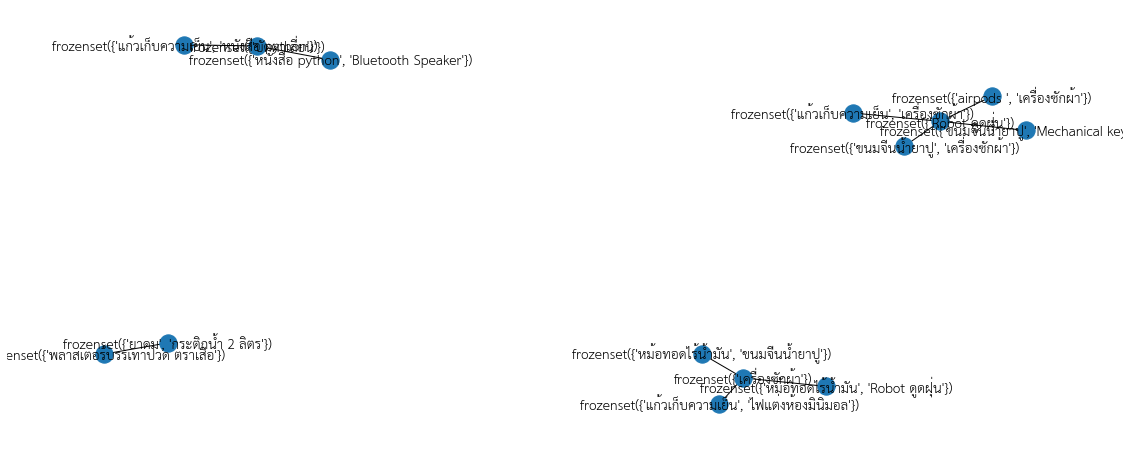

In [31]:
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('THSarabunChula-Regular.ttf')
mpl.rc('font', family='TH Sarabun Chula')
import networkx as nx

fig, ax=plt.subplots(figsize=(20,8))
GA=nx.from_pandas_edgelist(rules,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True,font_family='TH Sarabun Chula', font_size = 20)
plt.show()

In [32]:
item_item_matrix = pd.DataFrame(index=hot_encoded_df.columns,columns=hot_encoded_df.columns)

In [33]:
from scipy.spatial.distance import cosine

for i in range(0,len(item_item_matrix.columns)) :
    # Loop through the columns for each column
    for j in range(0,len(item_item_matrix.columns)) :
      # Fill in placeholder with cosine similarities
      item_item_matrix.iloc[i,j] = 1 -cosine(hot_encoded_df.iloc[:,i],hot_encoded_df.iloc[:,j])

In [34]:
links = item_item_matrix.rename_axis('related item', 
                                     axis='columns').stack().reset_index()
links.columns = ['item', 'related item','value']

In [40]:
links_filtered=links.loc[ (links['value'] > 0.8) & 
                         (links['item'] != links['related item']) ]

# Item ที่ควร Recommend เมื่อซื้อสิ่งใดสิ่งหนึ่งต่อไปนี้

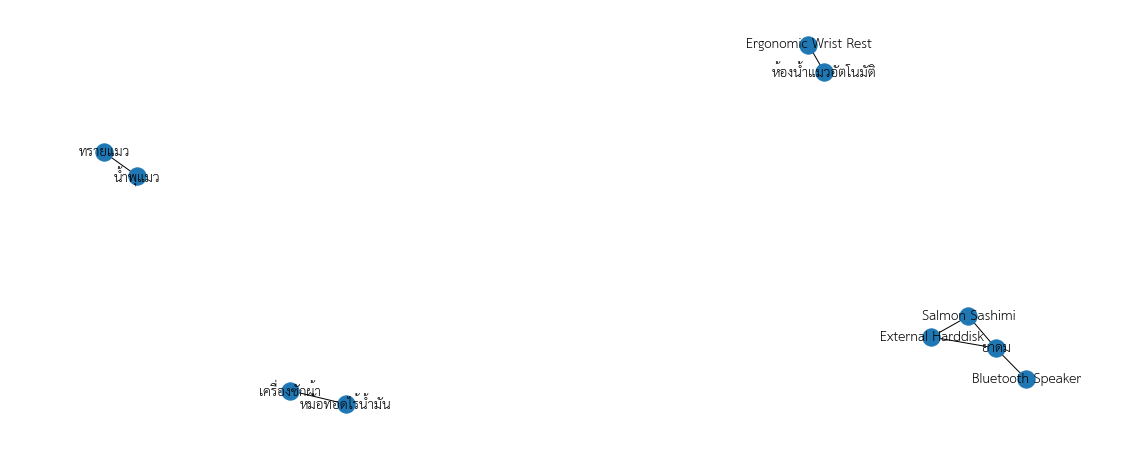

In [42]:
import matplotlib.pyplot as plt
import networkx as nx

fig, ax=plt.subplots(figsize=(20,8))
GA=nx.from_pandas_edgelist(links_filtered,source='item',target='related item')
nx.draw(GA,with_labels=True,font_family='TH Sarabun Chula', font_size = 20)
plt.show()